In [66]:
import polars as pl
from polars import Float32, Float64, Int32, Int64
from sklearn.linear_model import LinearRegression

from matplotlib import pyplot as plt

In [24]:
Float32

True

In [2]:
df = pl.read_parquet('../merged_dfs/df_all.parquet')

In [78]:
X = df[[x[0] for x in list(df.schema.items()) if \
        x[1].is_numeric() and \
        x[0] != 'traffic' and \
        x[0] != 'lat' and \
        x[0] != 'lon' and \
        x[0] != 'hour']]
y = df['traffic']

In [79]:
X.columns

['Residential_0.5',
 'Service_0.5',
 'Work_0.5',
 'Residential_1',
 'Service_1',
 'Work_1',
 'Residential_1.5',
 'Service_1.5',
 'Work_1.5',
 'Residential_2',
 'Service_2',
 'Work_2',
 'total_0.5',
 'female0018_0.5',
 'female1964_0.5',
 'female6599_0.5',
 'male0018_0.5',
 'male1964_0.5',
 'male6599_0.5',
 'total_1',
 'female0018_1',
 'female1964_1',
 'female6599_1',
 'male0018_1',
 'male1964_1',
 'male6599_1',
 'total_2',
 'female0018_2',
 'female1964_2',
 'female6599_2',
 'male0018_2',
 'male1964_2',
 'male6599_2',
 'total_3',
 'female0018_3',
 'female1964_3',
 'female6599_3',
 'male0018_3',
 'male1964_3',
 'male6599_3',
 'accommodation_0.5',
 'active_life_0.5',
 'arts_and_entertainment_0.5',
 'attractions_and_activities_0.5',
 'automotive_0.5',
 'beauty_and_spa_0.5',
 'business_to_business_0.5',
 'eat_and_drink_0.5',
 'education_0.5',
 'financial_service_0.5',
 'health_and_medical_0.5',
 'home_service_0.5',
 'mass_media_0.5',
 'pets_0.5',
 'private_establishments_and_corporates_0.5',

In [80]:
val_idx = df['station_id'].is_in(df['station_id'].unique().shuffle()[:10])

X_train = X.filter(~val_idx)
y_train = y.filter(~val_idx)

X_val = X.filter(val_idx)
y_val = y.filter(val_idx)

In [81]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

model = XGBRegressor()
model.fit(X_train, y_train)

# Predictions
train_preds = model.predict(X_train)
val_preds = model.predict(X_val)

# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, train_preds))
rmse_val = np.sqrt(mean_squared_error(y_val, val_preds))

print(f"Train RMSE: {rmse_train:.4f}")
print(f"Validation RMSE: {rmse_val:.4f}")

Train RMSE: 271.0007
Validation RMSE: 2012.9177


In [82]:
model = XGBRegressor(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1,
    reg_lambda=5,
    random_state=42
)

model.fit(X_train, y_train)

train_preds = model.predict(X_train)
val_preds = model.predict(X_val)

rmse_train = np.sqrt(mean_squared_error(y_train, train_preds))
rmse_val = np.sqrt(mean_squared_error(y_val, val_preds))

print(f"Train RMSE: {rmse_train:.4f}")
print(f"Validation RMSE: {rmse_val:.4f}")

Train RMSE: 384.6229
Validation RMSE: 1753.6016


In [83]:
# Train initial model
model = XGBRegressor(n_estimators=100, random_state=42)
model.fit(X_train.to_numpy(), y_train.to_numpy())

# Get top 50 important features by name
importances = model.feature_importances_
feature_names = X_train.columns
top_idx = np.argsort(importances)[::-1][:50]
top_features = [feature_names[i] for i in top_idx]

# Select top features with Polars
X_train_sel = X_train.select(top_features)
X_val_sel = X_val.select(top_features)

lr = LinearRegression()

lr.fit(X_train_sel, y_train)
train_preds_lr = lr.predict(X_train_sel.to_numpy())
val_preds_lr = lr.predict(X_val_sel.to_numpy())

rmse_train = np.sqrt(mean_squared_error(y_train.to_numpy(), train_preds_lr))
rmse_val = np.sqrt(mean_squared_error(y_val.to_numpy(), val_preds_lr))

# Train again on reduced set
model_sel = XGBRegressor(
    n_estimators=1000,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=4,
    reg_lambda=10,
    random_state=42
)
model_sel.fit(X_train_sel.with_columns(pl.Series(train_preds_lr).alias("lr_prediction")).to_numpy(), y_train.to_numpy())

# Predict and evaluate
train_preds = model_sel.predict(X_train_sel.with_columns(pl.Series(train_preds_lr).alias("lr_prediction")).to_numpy())
val_preds = model_sel.predict(X_val_sel.with_columns(pl.Series(val_preds_lr).alias("lr_prediction")).to_numpy())

rmse_train = np.sqrt(mean_squared_error(y_train.to_numpy(), train_preds))
rmse_val = np.sqrt(mean_squared_error(y_val.to_numpy(), val_preds))

print(f"Train RMSE: {rmse_train:.4f}")
print(f"Validation RMSE: {rmse_val:.4f}")

G:\wec2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
G:\wec2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Train RMSE: 431.2674
Validation RMSE: 1910.4221


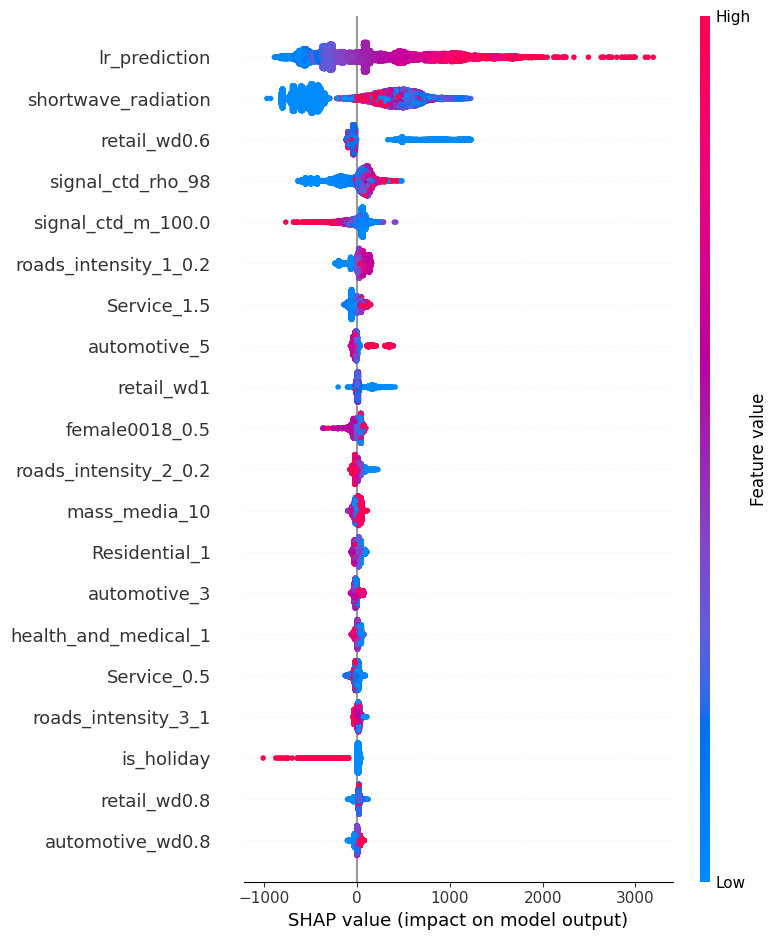

In [85]:
import shap

# Explain the model's predictions using SHAP
explainer = shap.Explainer(model_sel)
shap_values = explainer(X_val_sel.with_columns(pl.Series(val_preds_lr).alias("lr_prediction")).to_numpy())

# Summary plot (for top features)
shap.summary_plot(shap_values, features=X_val_sel.with_columns(pl.Series(val_preds_lr).alias("lr_prediction")).to_pandas(), feature_names=X_val_sel.with_columns(pl.Series(val_preds_lr).alias("lr_prediction")).columns)

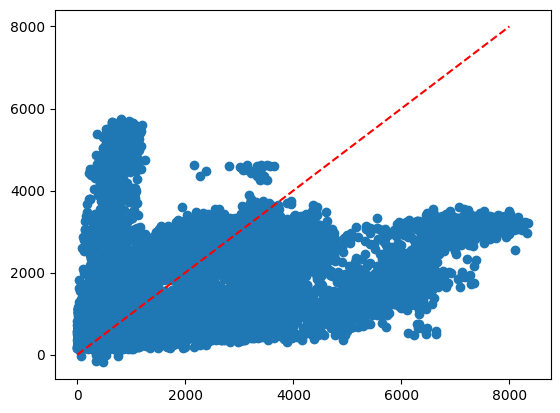

In [86]:
plt.scatter(y_val.to_numpy(), val_preds)
plt.plot([0, 8000], [0, 8000], 'r--')

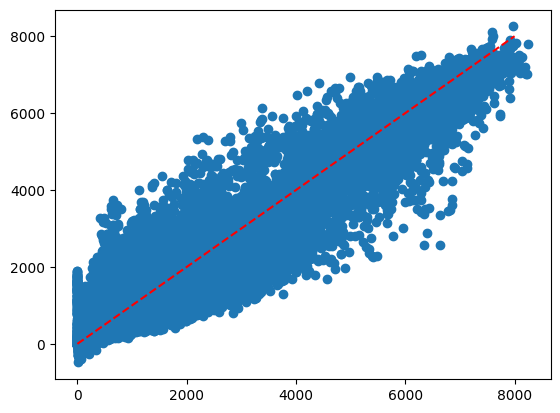

In [87]:
plt.scatter(y_train.to_numpy(), train_preds)
plt.plot([0, 8000], [0, 8000], 'r--')

In [88]:
lr = LinearRegression()

lr.fit(X_train_sel, y_train)
train_preds_lr = lr.predict(X_train_sel.to_numpy())
val_preds_lr = lr.predict(X_val_sel.to_numpy())

rmse_train = np.sqrt(mean_squared_error(y_train.to_numpy(), train_preds_lr))
rmse_val = np.sqrt(mean_squared_error(y_val.to_numpy(), val_preds_lr))

print(f"Train RMSE: {rmse_train:.4f}")
print(f"Validation RMSE: {rmse_val:.4f}")

Train RMSE: 891.1548
Validation RMSE: 2001.2413


G:\wec2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
G:\wec2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


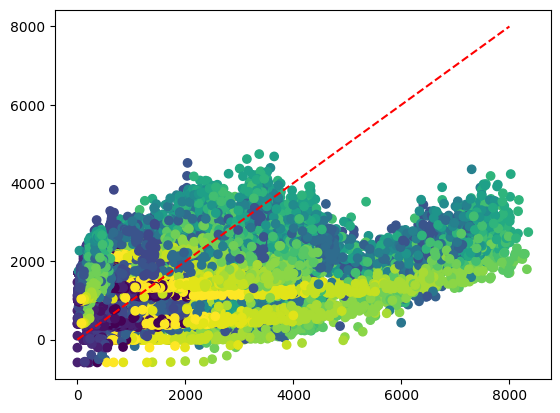

In [92]:
cmap = plt.get_cmap("viridis")  # or 'plasma', 'tab20', etc.
norm = plt.Normalize(vmin=0, vmax=23)
colors = cmap(norm(df.filter(val_idx)['hour']))


plt.scatter(y_val.to_numpy(), val_preds_lr, c=colors)
plt.plot([0, 8000], [0, 8000], 'r--')

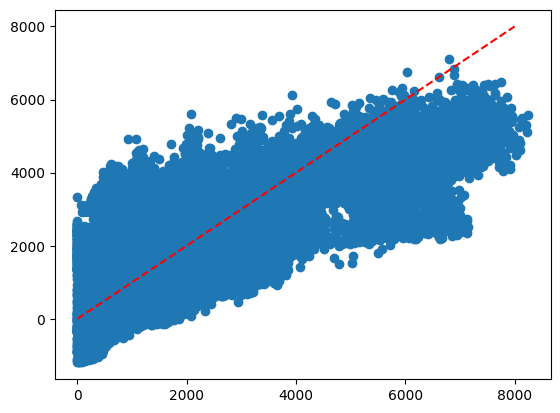

In [90]:
plt.scatter(y_train.to_numpy(), train_preds_lr)
plt.plot([0, 8000], [0, 8000], 'r--')